<a href="https://colab.research.google.com/github/DiploDatos/AprendizajeProfundo/blob/master/4_mlflow_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctico 1 - Deep Learning

**Integrantes:**
* Diego Flores
* Ignacio Villagra Torcomian

In [39]:
!curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/SBWCE/SBW-vectors-300-min5.txt.bz2 -o SBW-vectors-300-min5.txt.bz2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  780M  100  780M    0     0  34.0M      0  0:00:22  0:00:22 --:--:-- 34.3M


# IMPORTS

In [1]:
import gzip
import mlflow
import pandas as pd
import tempfile
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import bz2
import seaborn

from gensim import corpora
from gensim.parsing import preprocessing
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm, trange

In [2]:
torch.__version__

'1.10.1+cu111'

# READ DATA

Por razones de tiempo, solo utilizaremos una muestra de 500 mil filas del conjunto de entrenamiento. Considerando que esas filas representan solo el 80% de nuestro dataset, se utilizarán 125 mil filas del conjunto de validación para hacer la prueba para mantener esa participación 80/20 entre train y test.

In [3]:
train_df = pd.read_json("./data/meli-challenge-2019/spanish.train.jsonl.gz",lines=True,
                             orient='records'
                        ,nrows=500000
                       )

In [4]:
train_df.head(), train_df.shape

(  language label_quality                                              title  \
 0  spanish      reliable                    Casita Muñecas Barbies Pintadas   
 1  spanish    unreliable                       Neceser Cromado Holográfico    
 2  spanish    unreliable               Funda Asiento A Medida D20 Chevrolet   
 3  spanish    unreliable  Embrague Ford Focus One 1.8 8v Td (90cv) Desde...   
 4  spanish    unreliable  Bateria Panasonic Dmwbcf10 Lumix Dmc-fx60n Dmc...   
 
                  category  split  \
 0              DOLLHOUSES  train   
 1           TOILETRY_BAGS  train   
 2         CAR_SEAT_COVERS  train   
 3  AUTOMOTIVE_CLUTCH_KITS  train   
 4        CAMERA_BATTERIES  train   
 
                                      tokenized_title  \
 0               [casita, muñecas, barbies, pintadas]   
 1                    [neceser, cromado, holográfico]   
 2                [funda, asiento, medida, chevrolet]   
 3                       [embrague, ford, focus, one]   
 4  [bate

In [5]:
test_df = pd.read_json("./data/meli-challenge-2019/spanish.validation.jsonl.gz",lines=True, orient='records'
                       , nrows=125000
                      )

In [6]:
test_df.head(), test_df.shape

(  language label_quality                                              title  \
 0  spanish    unreliable                           Metal Biela Dw10 Hdi 2.0   
 1  spanish    unreliable  Repuestos Martillo Rotoprcutor Bosch Gshsce Po...   
 2  spanish    unreliable  Pesca Caña Pejerrey Colony Brava 3m Fibra De V...   
 3  spanish    unreliable  Porcelanato Abitare Be 20x120 Cm. Ceramica Por...   
 4  spanish    unreliable  Reconstruction Semi Di Lino Alfaparf Shampoo 1...   
 
                          category       split  \
 0                 ENGINE_BEARINGS  validation   
 1     ELECTRIC_DEMOLITION_HAMMERS  validation   
 2                    FISHING_RODS  validation   
 3                 PORCELAIN_TILES  validation   
 4  HAIR_SHAMPOOS_AND_CONDITIONERS  validation   
 
                                      tokenized_title  \
 0                                [metal, biela, hdi]   
 1  [repuestos, martillo, rotoprcutor, bosch, gshs...   
 2  [pesca, caña, pejerrey, colony, brava, fi

In [7]:
train_df.head()

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
0,spanish,reliable,Casita Muñecas Barbies Pintadas,DOLLHOUSES,train,"[casita, muñecas, barbies, pintadas]","[50001, 2, 50000, 3]",0,632,4895280
1,spanish,unreliable,Neceser Cromado Holográfico,TOILETRY_BAGS,train,"[neceser, cromado, holográfico]","[6, 4, 5]",1,632,4895280
2,spanish,unreliable,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS,train,"[funda, asiento, medida, chevrolet]","[9, 7, 10, 8]",2,632,4895280
3,spanish,unreliable,Embrague Ford Focus One 1.8 8v Td (90cv) Desde...,AUTOMOTIVE_CLUTCH_KITS,train,"[embrague, ford, focus, one]","[11, 13, 12, 14]",3,632,4895280
4,spanish,unreliable,Bateria Panasonic Dmwbcf10 Lumix Dmc-fx60n Dmc...,CAMERA_BATTERIES,train,"[bateria, panasonic, dmwbcf, lumix, dmc, fxn, ...","[15, 19, 17, 18, 16, 1, 1, 1]",4,632,4895280


# DATA ANALYSIS

A partir de una breve inspección del dataset, observamos que hay 632 categorías en total para clasificar ("n_labels") y que ya hay una columna con los títulos tokenizados ("tokenized_title") que es la que utilizaremos para entrenar el modelo

In [11]:
train_df.category.nunique()

632

In [12]:
train_df['tokenized_title'] = train_df['tokenized_title'].apply(' '.join)
test_df['tokenized_title'] = test_df['tokenized_title'].apply(' '.join)

In [13]:
# Nos quedamos solo con las columnas que nos interesan para el modelo: el título tokenizado y la categoría.
columns = ['tokenized_title', 'category']
train_df = train_df[columns]
test_df = test_df[columns]

In [14]:
# El conjunto de entrenamiento no tiene valores nulos
train_df.isna().sum()

tokenized_title    0
category           0
dtype: int64

In [15]:
# El conjunto de prueba tampoco tiene datos nulos
test_df.isna().sum()

tokenized_title    0
category           0
dtype: int64

In [16]:
# Breve análisis para observar las categorías más repetidas en el dataset
train_df.category.value_counts()

ACTION_FIGURES                   1555
BOOKS                            1552
FOOTBALL_SHIRTS                  1522
WRISTWATCHES                     1512
DIECAST_VEHICLES                 1493
                                 ... 
TANDEM_CHAIRS                      70
COIL_BINDING_MACHINES              63
INDUSTRIAL_ICE_CREAM_MACHINES      55
SCREEN_PRINTING_FRAMES             39
MOTORCYCLE_EXHAUSTS                23
Name: category, Length: 632, dtype: int64

In [17]:
torch.cuda.is_available() #Si devuelve True, entonces estamos usando la GPU

True

## Dataset

In [18]:
class MELIDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.to_list()
        
        item = {
            "data": self.dataset.loc[item, "tokenized_title"],
            "target": self.dataset.loc[item, "category"]
        }
        
        if self.transform:
            item = self.transform(item)
        
        return item

## Preprocesamiento

Sabemos que el título viene tokenizado, esto quiere decir que ya tiene hecho un preprocesamiento que quitó las stop words, signos de puntuación, números, etc, por lo que lo único que haremos es aplicarle la función "lower" para pasar alguna palabra o letra que haya quedado en mayúscula a minúsculas.

In [19]:
class RawDataProcessor:
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=100000):
        if filters:
            self.filters = filters
        else:
            self.filters = [
                lambda s: s.lower(),
            ]
        
        # Create dictionary based on all the reviews (with corresponding preprocessing)
        # https://radimrehurek.com/gensim/corpora/dictionary.html
        self.dictionary = corpora.Dictionary(
            dataset["tokenized_title"].map(self._preprocess_string).tolist()
        )
        # Filter the dictionary with extremos words
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.filter_extremes.html?highlight=filter_extrem
        self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        
        # Make the indices continuous after some words have been removed
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.compactify.html
        self.dictionary.compactify()
        self.idx_to_target = sorted(dataset["category"].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}


    def _preprocess_string(self, string):
        # https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string:~:text=gensim.parsing.preprocessing.preprocess_string
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _sentence_to_indices(self, sentence):
      # https://radimrehurek.com/gensim/corpora/dictionary.html#:~:text=doc2idx(document,via%20unknown_word_index.
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)
    
    def encode_data(self, data):
        return self._sentence_to_indices(self._preprocess_string(data))
    
    def encode_target(self, target):
        return self.target_to_idx[target]
    
    def __call__(self, item):
        if isinstance(item["data"], str):
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
        
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
        
        return {
            "data": data,
            "target": target
        }

## Lectura de datos
Concatenamos tanto el conjunto de prueba como el de validación para poder tener un único preprocess para todo el dataset. Luego, volvemos a separarlos (80% para prueba, 20% validación) para poder correr el modelo

In [20]:
dataset = pd.concat([train_df, test_df])
dataset.reset_index(drop=True, inplace=True)

preprocess = RawDataProcessor(dataset)

train_indices, test_indices = train_test_split(dataset.index, test_size=0.2, random_state=42)

train_dataset = MELIDataset(dataset.loc[train_indices].reset_index(drop=True), transform=preprocess)

test_dataset = MELIDataset(dataset.loc[test_indices].reset_index(drop=True), transform=preprocess)

print(f"Datasets loaded with {len(train_dataset)} training elements and {len(test_dataset)} test elements")
print(f"Sample train element:\n{train_dataset[0]}")
print(f"Sample train element:\n{test_dataset[0]}")

Datasets loaded with 500000 training elements and 125000 test elements
Sample train element:
{'data': [1305, 2437, 15145], 'target': 560}
Sample train element:
{'data': [2797, 2799, 269, 70, 1666, 70, 7724], 'target': 94}


## Collation function

Como en este caso trabajamos con secuencias de palabras (representadas por sus índices en un vocabulario), cuando queremos buscar un *batch* de datos, el `DataLoader` de PyTorch espera que los datos del *batch* tengan la misma dimensión (para poder llevarlos todos a un tensor de dimensión fija). Esto lo podemos lograr mediante el parámetro de `collate_fn`. En particular, esta función se encarga de tomar varios elementos de un `Dataset` y combinarlos de manera que puedan ser devueltos como un tensor de PyTorch. Muchas veces la `collate_fn` que viene por defecto en `DataLoader` sirve, pero este no es el caso. Se define un módulo `PadSequences` que toma un valor mínimo, opcionalmente un valor máximo y un valor de relleno (*pad*) y dada una lista de secuencias, devuelve un tensor con *padding* sobre dichas secuencias.

In [21]:
class PadSequences:
    def __init__(self, pad_value=0, max_length=None, min_length=1):
        assert max_length is None or min_length <= max_length
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            max_length = max(self.min_length, max(seq_lengths))

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
            
        return {
            "data": torch.LongTensor(data),
            "target": torch.FloatTensor(target)
        }

## DataLoaders

Ya habiendo definido nuestros conjuntos de datos y nuestra `collation_fn`, podemos definir nuestros `DataLoader`, uno para entrenamiento y otro para evaluación. Ver que la diferencia fundamental está en `shuffle`, no queremos mezclar los valores de evaluación cada vez que evaluamos porque al evaluar mediante *mini-batchs* nos puede generar inconsistencias.

In [22]:
pad_sequences = PadSequences()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,
                          collate_fn=pad_sequences, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False)

## El modelo de clasificación

Para clasificación utilizaremos un perceptrón multicapa de cuatro capas ocultas. Claramente este modelo es naive y prácticamente todo lo que está *hardcodeado* (e.g. los tamaños de las capas o la cantidad de capas) podría ser parte de los parámetros del modelo. En particular, tenemos la capa de `Embeddings` que es rellenada con los valores de embeddings preentrenados. Además, utilizamos la función de activación gelu que aplica esa transformación a las neuronas de las capas mencionadas anteriormente. No se hicieron pruebas con más capas por cuestiones de tiempo (a cada rato de nos caía Nabu y preferimos priorizar completar el entrenamiento del modelo). No obstante, sí se hicieron pruebas con menos capas y modificando los valores de entrada y salida de cada una, aunque las métricas finales resultaron peores. Por lo tanto, se terminaron eligiendo las capas y valores que se muestran a continuación por haber sido las de mejor rendimiento en cuanto a performance y tiempo de ejecución.

In [23]:
class MLP(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        super().__init__()
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        
        self.hidden_layer1 = nn.Linear(vector_size, 1024)
        self.hidden_layer2 = nn.Linear(1024, 4096)
        self.hidden_layer3 = nn.Linear(4096, 2048)
        self.hidden_layer4 = nn.Linear(2048, 1024)
        self.output_layer = nn.Linear(1024, 632) 
    
    def forward(self, x):
        x = self.embeddings(x)
        x = torch.mean(x, dim=1)
        x = self.hidden_layer1(x)  # Go through hidden layer 1
        x = F.gelu(x)  # Activation Function layer 1
        x = self.hidden_layer2(x) # Go through hidden layer 2
        x = F.gelu(x)  # Activation Function layer 2
        x = self.hidden_layer3(x) # Go through hidden layer 3
        x = F.gelu(x)  # Activation Function layer 3
        x = self.hidden_layer4(x) # Go through hidden layer 4
        x = F.gelu(x)  # Activation Function layer 4
        x = self.output_layer(x)
        return x

Definimos las funciones de entrenamiento y evaluación por separado para ayudar a la legibilidad de los experimentos

In [24]:
def train(model, optimizer, loss_function, trainloader, epochs, use_tqdm=True):
    model.train()  # Tell the model to set itself to "train" mode.
    for epoch in range(EPOCHS):  # loop over the dataset multiple times
        running_loss = 0.0 #Put loss in 0
        pbar = tqdm(train_loader) # 
        for i, data in enumerate(pbar, 1):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data["data"].to(device)
            labels = data["target"].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_function(outputs, labels.squeeze().long())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i > 0 and i % 50 == 0:    # print every 50 mini-batches
                pbar.set_description(f"[{epoch + 1}, {i}] loss: {running_loss / 50:.4g}")
                running_loss = 0.0

Utilizaremos el accuracy como métrica principal y el f1-score como métrica secundaria para la evaluación del modelo

In [25]:
def eval(model, dataloader, prefix='test_', use_tqdm=True):
    model.eval();  # Activate evaluation mode
    y_true = []
    y_pred = []
    with torch.no_grad():
        pbar = tqdm(dataloader) if use_tqdm else dataloader
        for data in pbar:
            inputs = data["data"].to(device)
            labels = data["target"].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return {
        prefix + 'balanced_accuracy_score': metrics.balanced_accuracy_score(y_true, y_pred),
        prefix + 'f1': metrics.f1_score(y_true, y_pred, average='macro'),
    }

## Primer modelo

Como función de costo a optimizar elegimos CrossEntropy, ya que es la indicada para problemas de clasificación. Además, elegimos un learning rate de 0.0001 y un weight decay de 0.0001 también. Hacemos la primera prueba usando Adam como algoritmo de optimización. Ya que la función de optimización CrossEntropy ya apllica softmax, por lo que no es necesario aplicar una función de activación en la capa de salida del modelo

In [27]:
def run_experiment(model, epochs, trainloader, testloader):
    loss_function = nn.CrossEntropyLoss()
    lr = 0.0001
    weight_decay=0.0001
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) 
    train(model, optimizer, loss_function, trainloader, epochs)
    test_results = eval(model, testloader)

    experiment = {
        'arquitecture': str(model), 'loss': str(loss_function),
        'lr': lr, 'epochs': epochs,
    }
    experiment.update(test_results)
    return experiment

En una primera instancia, definimos solo 2 Epochs. Esto también lo hacemos por una cuestión de tiempo y por algunos contratiempos que sufrimos en cuanto Nabuconodosor y caída recurrente del kernel, entre otras. 

In [28]:
experiments = []
EPOCHS = 2

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [34]:
model = MLP("SBW-vectors-300-min5.txt.bz2", preprocess.dictionary, 300, True)  # It's important to re-define the model to avoid keep training an earlier version

In [35]:
model.to(device)

MLP(
  (embeddings): Embedding(67212, 300, padding_idx=0)
  (hidden_layer1): Linear(in_features=300, out_features=1024, bias=True)
  (hidden_layer2): Linear(in_features=1024, out_features=4096, bias=True)
  (hidden_layer3): Linear(in_features=4096, out_features=2048, bias=True)
  (hidden_layer4): Linear(in_features=2048, out_features=1024, bias=True)
  (output_layer): Linear(in_features=1024, out_features=632, bias=True)
)

In [36]:
experiment = run_experiment(model, EPOCHS, train_loader, test_loader)

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/977 [00:00<?, ?it/s]

In [37]:
experiment

{'arquitecture': 'MLP(\n  (embeddings): Embedding(67212, 300, padding_idx=0)\n  (hidden_layer1): Linear(in_features=300, out_features=1024, bias=True)\n  (hidden_layer2): Linear(in_features=1024, out_features=4096, bias=True)\n  (hidden_layer3): Linear(in_features=4096, out_features=2048, bias=True)\n  (hidden_layer4): Linear(in_features=2048, out_features=1024, bias=True)\n  (output_layer): Linear(in_features=1024, out_features=632, bias=True)\n)',
 'loss': 'CrossEntropyLoss()',
 'lr': 0.0001,
 'epochs': 2,
 'test_balanced_accuracy_score': 0.35705335056210386,
 'test_f1': 0.3608321025667542}

In [38]:
print('Accuracy:', experiment['test_balanced_accuracy_score'], 'F1:',  experiment['test_f1'])

Accuracy: 0.35705335056210386 F1: 0.3608321025667542


Como resultado se obtiene un accuracy de 0.35 y un F1 score de 0.36. Ambas métricas son bastante bajas, por lo que buscaremos modificar algunos hiperparámetros para mejorar la precisión del modelo.

En primer lugar, vamos a definir un segundo experimento para evaluar cuál es la combinación óptima de learning rate y optimzador.

In [32]:
def run_experiment2(model, epochs, train_loader, test_loader,
                   optimizer_class, lr, use_tqdm=False):
    loss_function = nn.CrossEntropyLoss()
    weight_decay=0.0001
    optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=weight_decay)
    train(model, optimizer, loss_function, train_loader, epochs,
          use_tqdm=use_tqdm)
    test_results = eval(model, test_loader, use_tqdm=use_tqdm)

    experiment = {
        'arquitecture': str(model), 'loss': str(loss_function),
        'epochs': epochs, 'lr': lr, 'optimizer': str(optimizer_class)
    }
    experiment.update(test_results)
    return experiment

Nuevamente, por cuestiones de demora en los tiempos de ejecución, se corrió la prueba para 3 optimizadores distintos (RMSprop, Adam y Adagrad) y 3 learning rates distintos (0.0001, 0.001 y 0.01) para encontrar la combinación óptima

In [33]:
op_experiments = []
for optimizer_class in [optim.RMSprop, optim.Adam, optim.Adagrad]:
    for lr in [0.0001, 0.001, 0.01]:
        print("Exploring ", optimizer_class, lr)
        experiment = run_experiment2(model, EPOCHS, train_loader, test_loader,
                                     optimizer_class=optimizer_class, lr=lr)
        op_experiments.append(experiment)

Exploring  <class 'torch.optim.rmsprop.RMSprop'> 0.0001


  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

Exploring  <class 'torch.optim.rmsprop.RMSprop'> 0.001


  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

Exploring  <class 'torch.optim.rmsprop.RMSprop'> 0.01


  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

Exploring  <class 'torch.optim.adam.Adam'> 0.0001


  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

Exploring  <class 'torch.optim.adam.Adam'> 0.001


  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

Exploring  <class 'torch.optim.adam.Adam'> 0.01


  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

Exploring  <class 'torch.optim.adagrad.Adagrad'> 0.0001


  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

Exploring  <class 'torch.optim.adagrad.Adagrad'> 0.001


  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

Exploring  <class 'torch.optim.adagrad.Adagrad'> 0.01


  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

In [34]:
for experiment in op_experiments:
    print(experiment['optimizer'], experiment['lr'], experiment['test_balanced_accuracy_score'], experiment['test_f1'])

<class 'torch.optim.rmsprop.RMSprop'> 0.0001 0.40119171361014916 0.41331289453050635
<class 'torch.optim.rmsprop.RMSprop'> 0.001 0.41221774752810475 0.4236740006889293
<class 'torch.optim.rmsprop.RMSprop'> 0.01 0.001790857235802917 2.0804411744313296e-05
<class 'torch.optim.adam.Adam'> 0.0001 0.03166578355489237 0.014419941690398395
<class 'torch.optim.adam.Adam'> 0.001 0.29669777589955093 0.2992836359947236
<class 'torch.optim.adam.Adam'> 0.01 0.0015822784810126582 9.23877166138559e-06
<class 'torch.optim.adagrad.Adagrad'> 0.0001 0.001737762058999552 1.6392354659507703e-05
<class 'torch.optim.adagrad.Adagrad'> 0.001 0.0037179556822840893 0.0003375000604021403
<class 'torch.optim.adagrad.Adagrad'> 0.01 0.03752537483585091 0.023654589594840948


In [35]:
data = pd.DataFrame(data=op_experiments)
data.head()

,arquitecture,loss,epochs,lr,optimizer,test_balanced_accuracy_score,test_f1
0,"MLP(\n (embeddings): Embedding(67212, 300, pa...",CrossEntropyLoss(),2,0.0001,<class 'torch.optim.rmsprop.RMSprop'>,0.401192,0.413313
1,"MLP(\n (embeddings): Embedding(67212, 300, pa...",CrossEntropyLoss(),2,0.0010,<class 'torch.optim.rmsprop.RMSprop'>,0.412218,0.423674
2,"MLP(\n (embeddings): Embedding(67212, 300, pa...",CrossEntropyLoss(),2,0.0100,<class 'torch.optim.rmsprop.RMSprop'>,0.001791,0.000021
3,"MLP(\n (embeddings): Embedding(67212, 300, pa...",CrossEntropyLoss(),2,0.0001,<class 'torch.optim.adam.Adam'>,0.031666,0.014420
4,"MLP(\n (embeddings): Embedding(67212, 300, pa...",CrossEntropyLoss(),2,0.0010,<class 'torch.optim.adam.Adam'>,0.296698,0.299284


<AxesSubplot:xlabel='lr', ylabel='test_balanced_accuracy_score'>

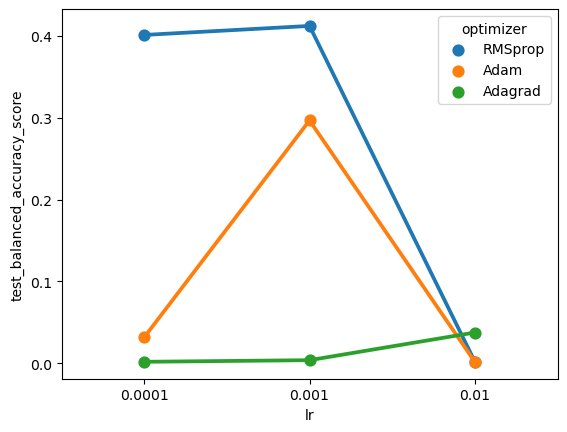

In [36]:
data = pd.DataFrame(data=op_experiments)
data['optimizer'] = data['optimizer'].apply(lambda x: x.split(".")[-1].strip("'>"))
seaborn.pointplot(
    data=data, x='lr', y='test_balanced_accuracy_score', hue='optimizer',)

Del análisis anterior podemos observar que el mejor accuracy se obtiene utilizando el optimizador RMSprop y lr=0.001 

# Overfitting y Underfitting

Seguidamente, queremos detectar si existe overfitting o undefitting en el modelo que estamos entrenando. 

In [23]:
def train_and_eval(model, optimizer, loss_function, train_loader, epochs,
                   valloader, use_tqdm=True):
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
    for epoch in range(epochs):  # loop over the dataset multiple times
        model.train()
        running_loss = 0.0
        pbar = tqdm(train_loader)
        for step, data in enumerate(pbar, 1):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data["data"].to(device)
            labels = data["target"].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_function(outputs, labels.squeeze().long())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if use_tqdm and step > 0 and step % 50 == 0:
                pbar.set_description(
                    f"[{epoch + 1}, {step}] loss: {running_loss / step:.4g}")
        history['train_loss'].append((epoch, running_loss / step))

        # At the end of the epoch, evaluate model on validation
        model.eval();  # Activate evaluation mode
        running_loss = 0.0
        y_true = []
        y_pred = []
        with torch.no_grad():
            pbar = tqdm(valloader) if use_tqdm else valloader
            for step, data in enumerate(pbar, 1):
                inputs = data["data"].to(device)
                labels = data["target"].type(torch.LongTensor)
                labels = labels.to(device)
                outputs = model(inputs)
                running_loss += loss_function(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        history['val_accuracy'].append(metrics.balanced_accuracy_score(y_true, y_pred))
        history['val_loss'].append((epoch, running_loss / step))
    
    return history

In [24]:
def run_experiment3(model, epochs, train_loader, test_loader,
                    optimizer_class=optim.RMSprop, lr=0.0001, weight_decay=0.0001,
                    use_tqdm=False):
    loss_function = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), lr=lr,
                                weight_decay=weight_decay)
    history = train_and_eval(
        model, optimizer, loss_function, train_loader, epochs,
        valloader=test_loader, use_tqdm=use_tqdm)
    test_results = eval(model, test_loader, use_tqdm=use_tqdm)

    experiment = {
        'arquitecture': str(model), 'loss': str(loss_function),
        'epochs': epochs, 'lr': lr, 'optimizer': str(optimizer_class),
        'weight_decay': weight_decay
    }
    experiment.update(history)
    experiment.update(test_results)
    return experiment

In [41]:
experiments = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MLP("SBW-vectors-300-min5.txt.bz2", preprocess.dictionary, 300, True)  # It's important to re-define the model to avoid keep training an earlier version
model.to(device)
experiment = run_experiment3(model, 20, train_loader, test_loader,
                             optimizer_class=optim.Adam, lr=0.0001)

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

<AxesSubplot:xlabel='epoch', ylabel='loss'>

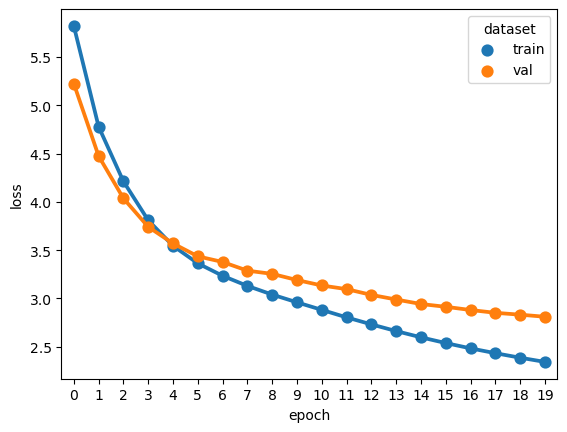

In [42]:
data = []
for epoch, (train_loss, val_loss) in enumerate(zip(
        experiment['train_loss'], experiment['val_loss'])):
    data.append((epoch, 'train', train_loss[1]))
    data.append((epoch, 'val', val_loss[1]))
data = pd.DataFrame(data=data, columns=['epoch', 'dataset', 'loss'])
seaborn.pointplot(
    data=data, x='epoch', y='loss', hue='dataset'
)

Del gráfico anterior podemos observar que el modelo efectivamente está aprendiendo, ya que la curva train sigue bajando la pérdida a medida que se incrementa la cantidad de epochs. Por otro lado, observamos que algo similar ocurre con el conjunto de validación aunque pareciera estar más cerca de llegar a un mínimo cuando va por la época 19. Se concluye que no hay ni overfitting (no sube la curva del conjunto de validaciónn) ni underfitting (sigue bajando la curva del conjunto train) pero sería óptimo incrementar el número de epochs.

Luego, queremos buscar cuál es el weight decay que minimza la función de pérdida. Por razones de tiempo y problemas recurrentes con el kernel, solo se hizo la prueba para 3 valores distintos de weight decay y tomando hasta 5 epochs. Los resultados se muestran a continuación:

In [26]:
wd_experiments = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for weight_decay in [0.0001, 0.001, 0.01]:
    print("Exploring weight_decay: ", weight_decay)
    model = MLP("SBW-vectors-300-min5.txt.bz2", preprocess.dictionary, 300, True).to(device)  # It's important to re-define the model to avoid keep training an earlier version
    wd_experiments.append(run_experiment3(
      model, 5, train_loader, test_loader,
      optimizer_class=optim.Adam, lr=0.0001, weight_decay=weight_decay,
      use_tqdm=True))

Exploring weight_decay:  0.0001


  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/977 [00:00<?, ?it/s]

Exploring weight_decay:  0.001


  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/977 [00:00<?, ?it/s]

Exploring weight_decay:  0.01


  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/977 [00:00<?, ?it/s]

In [28]:
wd_experiments
data = []
for experiment in wd_experiments:
    wd = experiment['weight_decay']
    for epoch, train_loss in experiment['train_loss']:
        data.append((epoch, wd, train_loss, 'train'))
    for epoch, val_loss in experiment['val_loss']:
        data.append((epoch, wd, val_loss, 'val'))
data = pd.DataFrame(data=data, columns=['epoch', 'weight_decay', 'loss', 'dataset'])
data[:3]

,epoch,weight_decay,loss,dataset
0,0,0.0001,5.796650,train
1,1,0.0001,4.829074,train
2,2,0.0001,4.277794,train


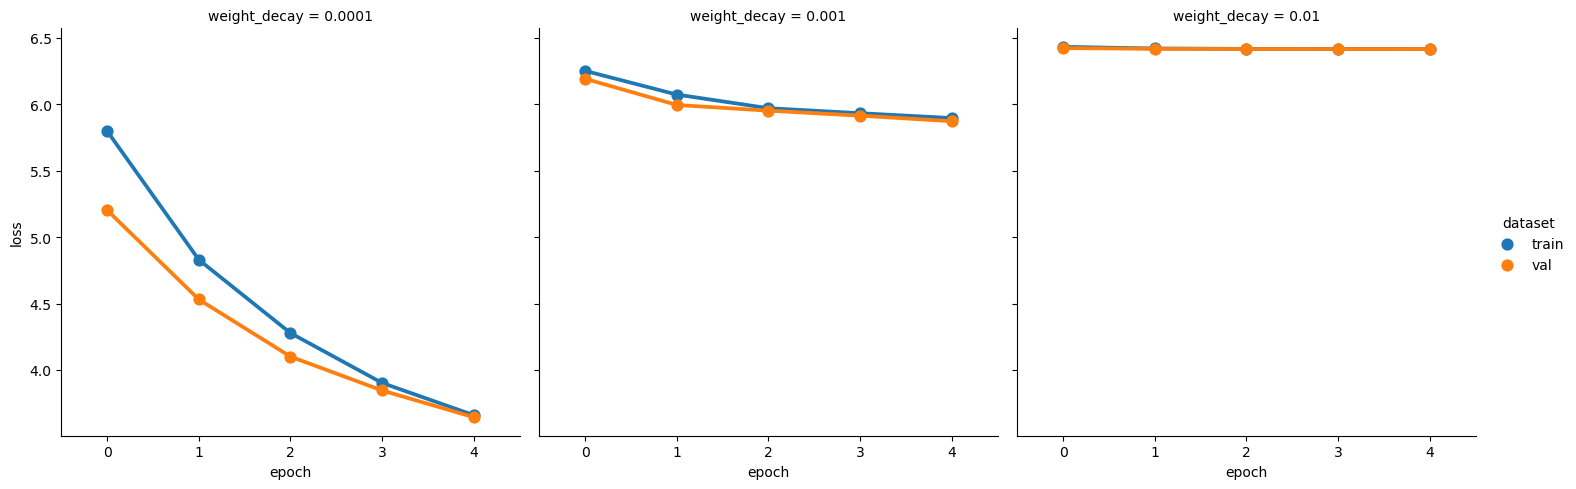

In [29]:
seaborn.catplot(
    data=data, x='epoch', y='loss', hue='dataset',
    col='weight_decay', col_wrap=3,
    kind='point'
);

Los resultados muestran que un weight decay de 0.0001, que es el que veníamos utilizando, el que minimiza la función de pérdida a medida que se incrementan las epochs tanto para el conjunto de entrenamiento como para el conjunto de validación

# Nuevo modelo

Tomando los resultados obtenidos, vamos a correr un nuevo modelo modificando lr, epochs y función optimizadora para ver si mejora el accuracy con respecto al modelo anterior. El weight decay no se modifica ya que se venía utlizando la mejor opción. 

In [31]:
def run_experiment_newmodel(model, epochs, trainloader, testloader):
    loss_function = nn.CrossEntropyLoss()
    lr = 0.001
    weight_decay=0.0001
    optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    train(model, optimizer, loss_function, trainloader, epochs)
    test_results = eval(model, testloader)

    experiment = {
        'arquitecture': str(model), 'loss': str(loss_function),
        'lr': lr, 'epochs': epochs,
    }
    experiment.update(test_results)
    return experiment

In [32]:
experiments = []
EPOCHS = 20

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [34]:
new_model = MLP("SBW-vectors-300-min5.txt.bz2", preprocess.dictionary, 300, True)  # It's important to re-define the model to avoid keep training an earlier version

In [35]:
new_model.to(device)

MLP(
  (embeddings): Embedding(67212, 300, padding_idx=0)
  (hidden_layer1): Linear(in_features=300, out_features=1024, bias=True)
  (hidden_layer2): Linear(in_features=1024, out_features=4096, bias=True)
  (hidden_layer3): Linear(in_features=4096, out_features=2048, bias=True)
  (hidden_layer4): Linear(in_features=2048, out_features=1024, bias=True)
  (output_layer): Linear(in_features=1024, out_features=632, bias=True)
)

In [36]:
experiment = run_experiment_newmodel(new_model, EPOCHS, train_loader, test_loader)

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/977 [00:00<?, ?it/s]

In [37]:
print('Accuracy:', experiment['test_balanced_accuracy_score'], 'F1:',  experiment['test_f1'])

Accuracy: 0.5005588211183766 F1: 0.5329205868750632


Se observa una notable mejora en las métricas de este nuevo modelo con respecto al modelo anterior (0.15 puntos en el accuracy). Si bien tenemos en claro que las métricas siguen siendo mejorables, por ejemplo, incrementando aun más la cantidad de epochs y agregando capas ocultas, por nombrar dos posibles mejoras, por cuestiones de tiempo se tuvieron que descartar posibles mejoras en este modelo ya que tuvimos inconvenientes técnicos cuando quisimos correr esos modelos.